# Bostrom supply simulation

---

## Rationale

There are three network tokens:

* T - liquid network token
* V - vested network token
* F - not claimed(frozen) network token

and two energy tokens:

* Am - Amper token
* Vo - Volt token

The initial state of all tokens should be defined below

* 1 **timestep** == 1 network block

## Claim function

The function of claim frozen tokens is:

\begin{gather}
\\
f(x) = -2.9 \cdot 10^7x + 7 \cdot 10^{14} \\
\\
\end{gather}

![](./images/claim.png)

where **x** is network block. This function means 80% of frozen tokens are going to be claimed in 3 years linearly by 29,000,000 tokens per block.

## Vesting and Unvesting

The vesting function is defined as the number of blocks in months for vesting all liquid tokens. This function recalculates every block.

The vesting function is defined as the number of blocks in months for investing all vested tokens. This function recalculates every block.

## Energy tokens

Amperes and Volts mints by the following formula:

\begin{gather}
\\
f(x) = \frac{x \cdot * vestingTime(s)}{1000000} \\
\\
\end{gather}

where **x** is number of vested tokens

## Inflation

The inflation function depends on the ratio between vested tokens and tokens supply. It the same as in cosmos-based networks. 

## Supply

Supply is the sum of liquid, vested and frozen tokens in each block.

## Assumptions

1. All agents lock tokens for the maximum available period defined in params for simulating
2. All agents mint maximum **Am** and **Vo** tokens in 50/50 ratio

## Initial state

In [1]:
tokens = 200_000_000_000_000 # Unfreeze and unvested liquid network tokens
frozen = 700_000_000_000_000 # Waiting for claim liquid network tokens
vested = 100_000_000_000_000 # Vested tokens according to genesis ceremony
init_inflation = 0.01        # Start inflation

## Params for simulating

In [2]:
inflation_rate_change = [0.13] # maximum inflation rate change per year
inflation_min = [0.01]         # minimum percent of the inflation
inflation_max = [0.15]         # minimum percent of the inflation
goal_vested = [0.88]           # desireable ratio between vested tokens and tokens supply
blocks_per_year = [6_311_520]  # desireable amount of blocks per year
max_vesting_time = [1_577_880] # max amount of blocks for locking
vesting_speed = [2]            # amount of months to vest all liquid tokens
unvesting_speed = [60]         # amount of months to uninvest all vested tokens 

sim_period = 12 * 5            # amount of months for simulating

## Mathematical Specification

### Differential Equations

* T - liquid network token
* V - vested network token
* F - not claimed(frozen) network token
* IRC_b - inflation rate change per block
* S - total network tokens supply
* I - inflation per block in network tokens
* BlockProvision - per block token provision
* Am - Amper token
* Vo - Volt token

\begin{gather}
\\
T_b = T_{b-1} + {\Delta T} \tag{1} \\
V_b = V_{b-1} + {\Delta V} \tag{2} \\
F_b = F_{b-1} + {\Delta F} \tag{3} \\
Am_b = Am_{b-1} + {\Delta Am} \tag{4} \\
Vo_b = Vo_{b-1} + {\Delta Vo} \tag{5} \\
S_b = T_b + V_b + F_b \tag{6} \\ 
\\
\end{gather}

where the rate of change ($\Delta$) is:
\begin{gather}
\\
{\Delta F} = -29000000 \tag{5} \\ \\
{\Delta V} = \frac{T_{b-1}}{(blocksPerYear*(1/12 \cdot vestingSpeed)} - {\Delta U} \tag{6} \\ \\
{\Delta T} = - {\Delta F} - {\Delta V} + I_{b-1} + {\Delta U}  \tag{7} \\ \\
{\Delta Am} = \frac{{\Delta V} * maxVestingTime * 5}{2 * 1000000}  \tag{8} \\ \\
{\Delta Vo} = \frac{{\Delta V} * maxVestingTime * 5}{2 * 1000000}  \tag{9} \\ \\
{\Delta U} = \frac{V_{b-1}}{(blocksPerYear*(1/12 \cdot unvestingSpeed)} \tag{10} \\ \\
\\
\end{gather}

where:
\begin{gather}
\\
I_{b-1} = \frac{S_{b-1} \cdot IRC_{b-1}}{blocksPerYear} \tag{11} \\ \\
IRC_b = \frac{\left(1 - \frac{vestedRatio_{b-1}}{goalVested}\right) \cdot inflationRateChange}{blocksPerYear} \tag{12} \\
\\
\end{gather}

In [3]:
# Standard libraries: https://docs.python.org/3/library/
import math

# Analysis and plotting modules
import pandas as pd
import plotly

In [4]:
# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

from collections import Counter
from cadCAD import configs

In [5]:
initial_state = {
    'T':   tokens,
    'F':   frozen,
    'V':   vested,
    'Am': 0,
    'Vo': 0,
    'd_u': 0,
    'I_r': init_inflation,
    'd_v': 0
}

system_params = {
    'inflationRateChange': inflation_rate_change,
    'inflationMin': inflation_min,
    'inflationMax': inflation_max,
    'goalVested': goal_vested,
    'blocksPerYear': blocks_per_year,
    'maxVestingTime': max_vesting_time,
    'vestingSpeed': vesting_speed,
    'unvestingSpeed': unvesting_speed
}

Adapting to use **policy functions** to drive the process, and **state update functions** to update the state according to the **differential specification**:

In [6]:
def p_inflation(params, substep, state_history, previous_state):
    S = previous_state['T'] + previous_state['F'] + previous_state['V']
    V_r = previous_state['V']/S
    IRC = (1 - (V_r/params['goalVested'])) * params['inflationRateChange']
    IRC = IRC / params['blocksPerYear']
    return {'IRC': IRC}

def p_blockProvision(params, substep, state_history, previous_state):
    S = previous_state['T'] + previous_state['F'] + previous_state['V']
    V_r = previous_state['V'] / S
    IRC = ((1 - V_r/params['goalVested']) * params['inflationRateChange']) / params['blocksPerYear']
    I_r = previous_state['I_r'] + IRC
    if I_r > params['inflationMax']:
        I_r = params['inflationMax']
    elif I_r < params['inflationMin']:
        I_r = params['inflationMin']
    I_p = (S * I_r) / params['blocksPerYear']
    return {'block_provision': math.ceil(I_p)}

def p_claim(params, substep, state_history, previous_state):
    delta_f = -29_000_000
    if previous_state['F'] <= 0:
        delta_f = 0
    return {'delta_F': delta_f}

def p_vest(params, substep, state_history, previous_state):
    investmint = previous_state['T']/(params['blocksPerYear'] * ((1/12) * params['vestingSpeed']))
    return {'delta_V': math.ceil(investmint)}

def p_unvest(params, substep, state_history, previous_state):
    if previous_state['timestep'] <= params['maxVestingTime']:
        uninvestmint = 0
    else:
        uninvestmint = previous_state['V']/(params['blocksPerYear'] * ((1/12) * params['unvestingSpeed']))
    return {'delta_U': math.ceil(uninvestmint)}

In [7]:
def s_I_r(params, substep, state_history, previous_state, policy_input):
    I_r = previous_state['I_r'] + policy_input['IRC']
    if I_r > params['inflationMax']:
        I_r = params['inflationMax']
    elif I_r < params['inflationMin']:
        I_r = params['inflationMin']
    return 'I_r', I_r

def s_F(params, substep, state_history, previous_state, policy_input):
    F = previous_state['F'] + policy_input['delta_F']
    if F < 0:
        F = 0
    return 'F', F

def s_V(params, substep, state_history, previous_state, policy_input):
    V = previous_state['V'] + policy_input['delta_V'] - policy_input['delta_U']
    return 'V', V

def s_T(params, substep, state_history, previous_state, policy_input):
    T = previous_state['T'] - policy_input['delta_F'] - policy_input['delta_V'] + policy_input['block_provision'] + policy_input['delta_U']
    return 'T', T

def s_d_u(params, substep, state_history, previous_state, policy_input):
    return 'd_u', policy_input['delta_U']

def s_d_v(params, substep, state_history, previous_state, policy_input):
    return 'd_v', policy_input['delta_V']

def s_am(params, substep, state_history, previous_state, policy_input):
    am = previous_state['Am'] + (policy_input['delta_V'] * params['maxVestingTime'] * 5) / 2_000_000
    return 'Am', am

def s_vo(params, substep, state_history, previous_state, policy_input):
    vo = previous_state['Vo'] + (policy_input['delta_V'] * params['maxVestingTime'] * 5) / 2_000_000
    return 'Vo', vo
    

In [8]:
partial_state_update_blocks = [
    {
        'policies': {
            'IRC': p_inflation,
            'block_provision': p_blockProvision, 
            'delta_F': p_claim, 
            'delta_V': p_vest,
            'delta_U': p_unvest
        },
        'variables': {
            'I_r': s_I_r,
            'F': s_F,
            'V': s_V,
            'T': s_T,
            'd_u': s_d_u,
            'd_v': s_d_v,
            'Am': s_am,
            'Vo': s_vo
        }
    }
]

In [9]:
del configs[:]
experiment = Experiment()

sim_config = config_sim({
    'N': 1,
    'T': range(int(math.ceil((6311520/12) * sim_period))),
    'M': system_params
})

experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

In [10]:
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (31557600, 8, 1, 8)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 1808.72s


In [11]:
simulation_result = pd.DataFrame(raw_result)
simulation_result

,T,F,V,Am,Vo,d_u,I_r,d_v,simulation,subset,run,substep,timestep
0,200000000000000,700000000000000,100000000000000,0.000000e+00,0.000000e+00,0,0.010000,0,0,0,1,0,0
1,199999840455881,699999971000000,100000190128527,7.500000e+08,7.500000e+08,0,0.010000,190128527,0,0,1,1,1
2,199999680911916,699999942000000,100000380256903,1.499999e+09,1.499999e+09,0,0.010000,190128376,0,0,1,1,2
3,199999521368106,699999913000000,100000570385127,2.249998e+09,2.249998e+09,0,0.010000,190128224,0,0,1,1,3
4,199999361824450,699999884000000,100000760513199,2.999996e+09,2.999996e+09,0,0.010000,190128072,0,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31557596,98690234184076,0,1745135325131602,1.027381e+16,1.027381e+16,55300001,0.137697,93819143,0,0,1,1,31557596
31557597,98690235891390,0,1745135363650745,1.027381e+16,1.027381e+16,55300002,0.137697,93819145,0,0,1,1,31557597
31557598,98690237598705,0,1745135402169888,1.027381e+16,1.027381e+16,55300003,0.137697,93819146,0,0,1,1,31557598
31557599,98690239306019,0,1745135440689032,1.027381e+16,1.027381e+16,55300004,0.137697,93819148,0,0,1,1,31557599


In [12]:
df = simulation_result.copy()
df['Supply'] = df['T'] + df['F'] + df['V']
df['AmPrice'] = df['Am'] / df['Supply']
df['ratio'] = df['V']/df['Supply']
df

,T,F,V,Am,Vo,d_u,I_r,d_v,simulation,subset,run,substep,timestep,Supply,AmPrice,ratio
0,200000000000000,700000000000000,100000000000000,0.000000e+00,0.000000e+00,0,0.010000,0,0,0,1,0,0,1000000000000000,0.000000e+00,0.100000
1,199999840455881,699999971000000,100000190128527,7.500000e+08,7.500000e+08,0,0.010000,190128527,0,0,1,1,1,1000000001584408,7.500000e-07,0.100000
2,199999680911916,699999942000000,100000380256903,1.499999e+09,1.499999e+09,0,0.010000,190128376,0,0,1,1,2,1000000003168819,1.499999e-06,0.100000
3,199999521368106,699999913000000,100000570385127,2.249998e+09,2.249998e+09,0,0.010000,190128224,0,0,1,1,3,1000000004753233,2.249998e-06,0.100001
4,199999361824450,699999884000000,100000760513199,2.999996e+09,2.999996e+09,0,0.010000,190128072,0,0,1,1,4,1000000006337649,2.999996e-06,0.100001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31557596,98690234184076,0,1745135325131602,1.027381e+16,1.027381e+16,55300001,0.137697,93819143,0,0,1,1,31557596,1843825559315678,5.572007e+00,0.946475
31557597,98690235891390,0,1745135363650745,1.027381e+16,1.027381e+16,55300002,0.137697,93819145,0,0,1,1,31557597,1843825599542135,5.572008e+00,0.946475
31557598,98690237598705,0,1745135402169888,1.027381e+16,1.027381e+16,55300003,0.137697,93819146,0,0,1,1,31557598,1843825639768593,5.572008e+00,0.946475
31557599,98690239306019,0,1745135440689032,1.027381e+16,1.027381e+16,55300004,0.137697,93819148,0,0,1,1,31557599,1843825679995051,5.572008e+00,0.946475


## Supply, liquid, frozen and vested tokens

<AxesSubplot:xlabel='timestep'>

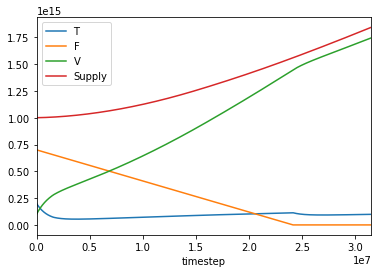

In [13]:
df.plot(kind='line', x='timestep', y=['T', 'F', 'V', 'Supply'])

## Amper(volt) tokens supply

<AxesSubplot:xlabel='timestep'>

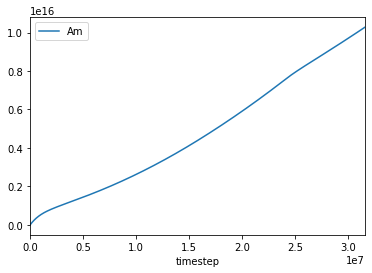

In [14]:
df.plot(kind='line', x='timestep', y=['Am'])

## Inflation

<AxesSubplot:xlabel='timestep'>

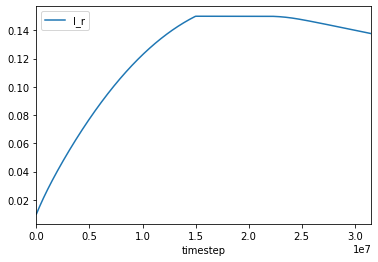

In [15]:
df.plot(kind='line', x='timestep', y=['I_r'])

## Increment of vested and unvested tokens

<AxesSubplot:xlabel='timestep'>

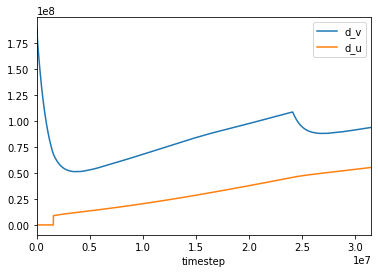

In [16]:
df.plot(kind='line', x='timestep', y=['d_v', 'd_u'])

## Vested ratio

<AxesSubplot:xlabel='timestep'>

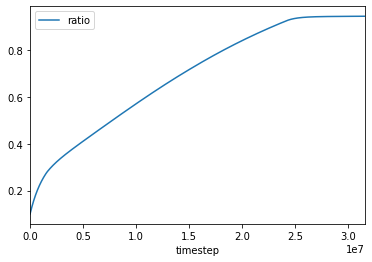

In [17]:
df.plot(kind='line', x='timestep', y=['ratio'])

## Ratio between amper(volt) supply and tokens supply

<AxesSubplot:xlabel='timestep'>

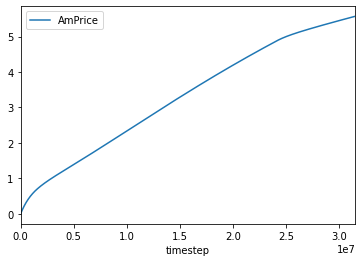

In [18]:
df.plot(kind='line', x='timestep', y=['AmPrice'])